In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

In [221]:
data = pd.read_csv("./data/augmented_data.csv")

In [222]:
data.nunique()

period                     5
minute                   139
possession               290
duration               78059
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               702
location_y_distance      472
technique                  7
body_part                  4
type                       5
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11912
pass_angle             10519
pass_type                  8
pass_height                4
pass_length             9930
num_passes                13
defenders_3m_radius       10
defenders_triangle        13
goalkeeper_x             258
goalkeeper_y             355
distance_to_goalie     45564
statsbomb_xg           82551
end_location_x           376
end_location_y           705
is_goal                    2
shot_angle    

In [223]:
# Use mutual_info classification to check which features yield the most information about the target variable
X = data.drop(["statsbomb_xg", "is_goal", "play_pattern", "technique", "position", "body_part", "type", "pass_height", "pass_type"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

end_location_x         0.092261
end_location_y         0.088554
distance_to_goalie     0.059173
defenders_triangle     0.039551
location_x             0.034775
location_x_distance    0.034749
goalkeeper_x           0.027983
defenders_3m_radius    0.023502
location_y             0.022767
duration               0.021866
goalkeeper_y           0.020304
location_y_distance    0.019919
shot_angle             0.012918
open_goal              0.012049
pass_duration          0.011166
pass_length            0.009500
period                 0.008878
num_passes             0.007423
one_on_one             0.004370
first_time             0.004150
pass_angle             0.003245
under_pressure         0.003245
minute                 0.002433
possession             0.002047
aerial_won             0.001074
follows_dribble        0.000154
dtype: float64

In [224]:
# drop redundant features
data.drop(["location_x", "location_y"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["duration", "shot_angle"], axis=1, inplace=True)
# drop low information features
data.drop(["aerial_won", "follows_dribble", "possession", "minute", "period", "num_passes", "pass_duration"], axis=1, inplace=True)
# "position", "body_part", "type", "pass_height", "pass_type"

In [225]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "position", "body_part", "type", "pass_height", "pass_type"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [226]:
data.nunique()

location_x_distance       635
location_y_distance       472
first_time                  2
open_goal                   2
one_on_one                  2
                         ... 
pass_type_Interception      2
pass_type_Kick Off          2
pass_type_Missing           2
pass_type_Recovery          2
pass_type_Throw-in          2
Length: 79, dtype: int64

In [227]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [228]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)

In [229]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84065 entries, 0 to 84064
Data columns (total 75 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   location_x_distance                 84065 non-null  float64
 1   location_y_distance                 84065 non-null  float64
 2   first_time                          84065 non-null  bool   
 3   open_goal                           84065 non-null  bool   
 4   one_on_one                          84065 non-null  bool   
 5   under_pressure                      84065 non-null  bool   
 6   pass_angle                          84065 non-null  float64
 7   pass_length                         84065 non-null  float64
 8   defenders_3m_radius                 84065 non-null  int64  
 9   defenders_triangle                  84065 non-null  int64  
 10  goalkeeper_x                        84065 non-null  float64
 11  goalkeeper_y                        84065

In [230]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [231]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.3).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [232]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [233]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [234]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [235]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [236]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=8, max_leaf_nodes=50, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [237]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.10, max_depth=8, min_samples_split=100, n_estimators=200, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [238]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.048244269280184514
Root Mean Squared Error: 0.07555292338349924
R-squared (R2 Score): 0.7467066526614118


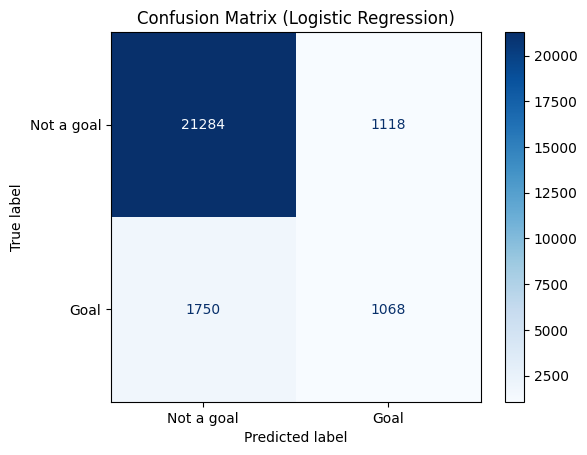


Logistic Regression
Accuracy: 0.8862807295796986
Precision: 0.4885635864592864
Recall: 0.37899219304471254
F1: 0.42685851318944845


In [239]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

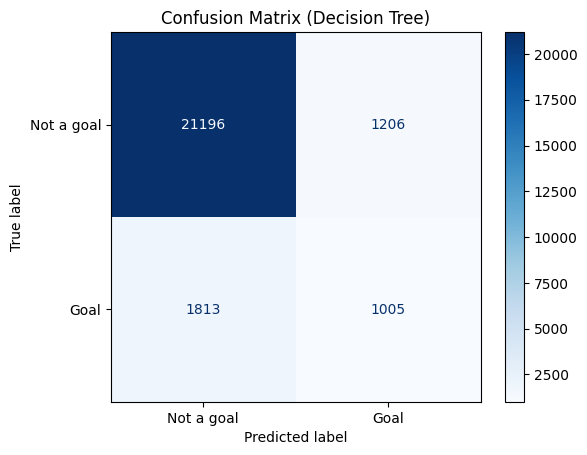


Decision Tree
Accuracy: 0.8802934179222839
Precision: 0.45454545454545453
Recall: 0.3566359119943222
F1: 0.3996818452972758


In [240]:
dt_xg, viz = decision_tree()

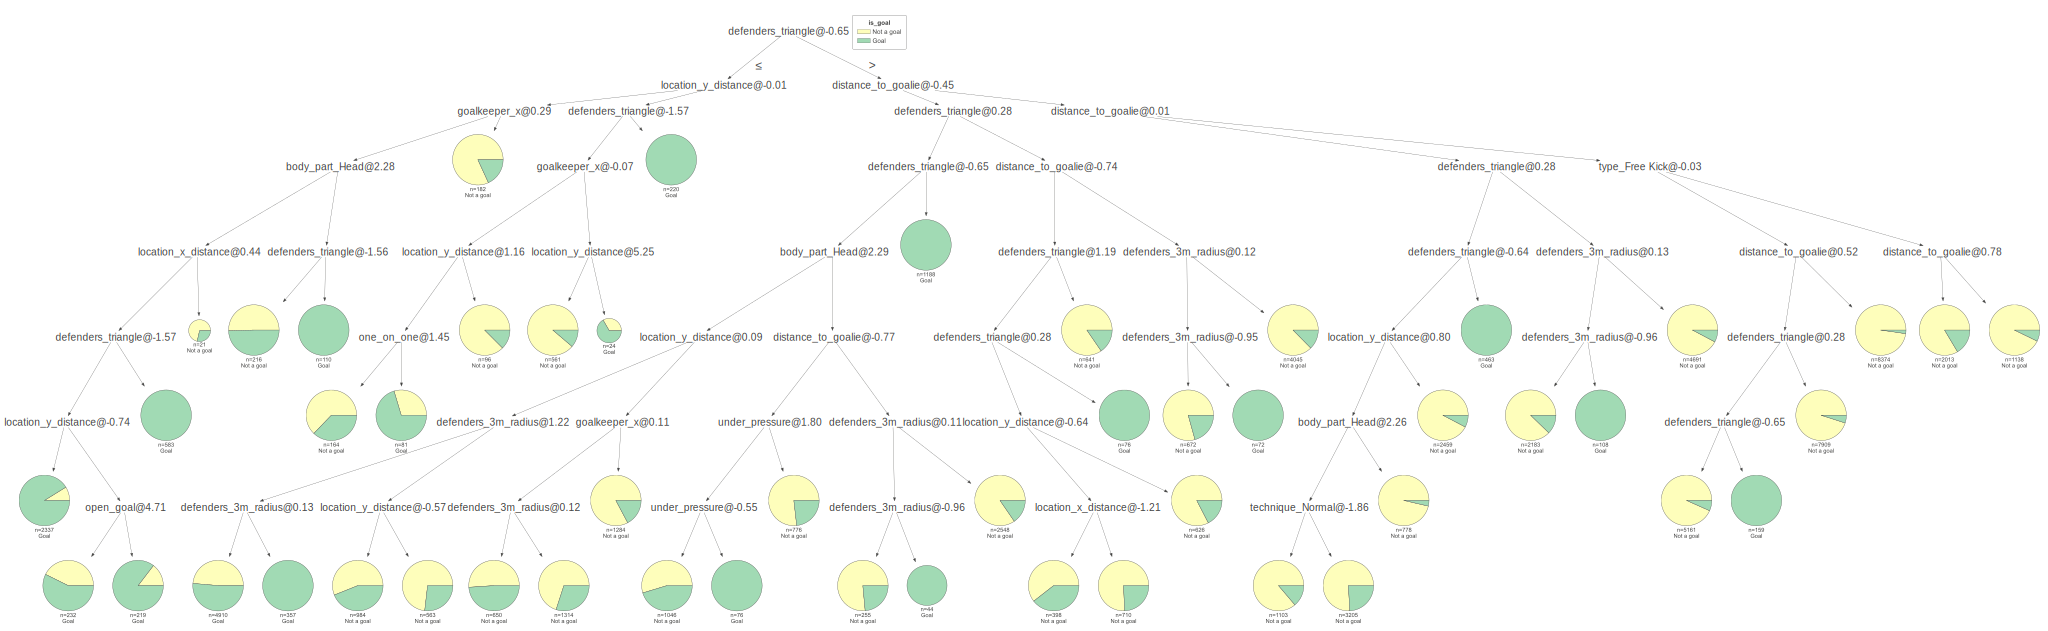

In [241]:
viz.view(fancy=False)

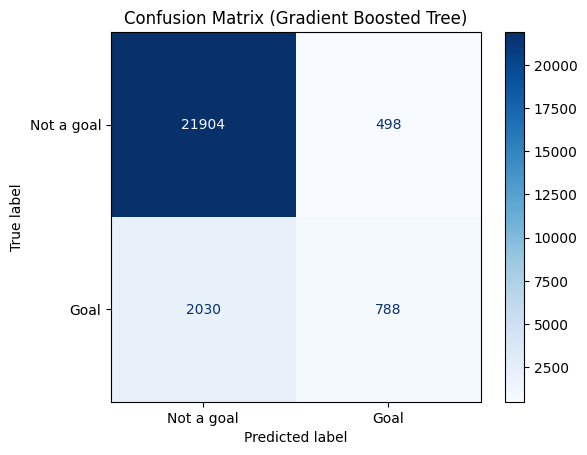


Gradient Boosted Tree
Accuracy: 0.8997620935765266
Precision: 0.6127527216174183
Recall: 0.27963094393186655
F1: 0.3840155945419103


In [242]:
gbt_xg = gradient_boosted_tree()

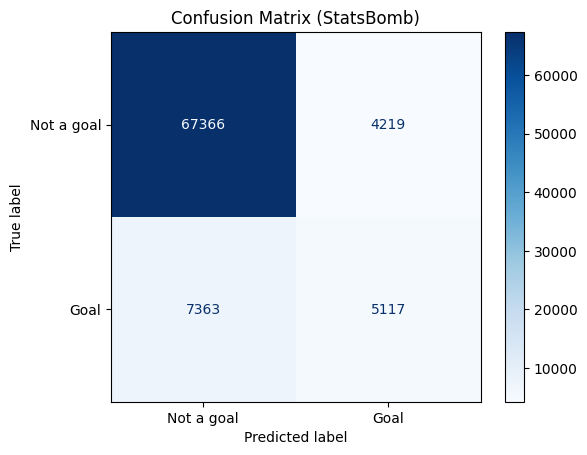


StatsBomb
Accuracy: 0.8622256587164694
Precision: 0.5480934018851756
Recall: 0.4100160256410256
F1: 0.4691052438577191


In [247]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
sb = data["statsbomb_xg"].apply(lambda x: math.ceil(x-0.18))
calculate_stats(sb, y2, "StatsBomb")

In [244]:
_, _, _, sxg = preprocess_continuous(X, y1)
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sxg})
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

          0         1
0  1.000000  0.864177
1  0.864177  1.000000
          0         1
0  1.000000  0.863033
1  0.863033  1.000000
          0         1
0  1.000000  0.848748
1  0.848748  1.000000
          0         1
0  1.000000  0.889075
1  0.889075  1.000000


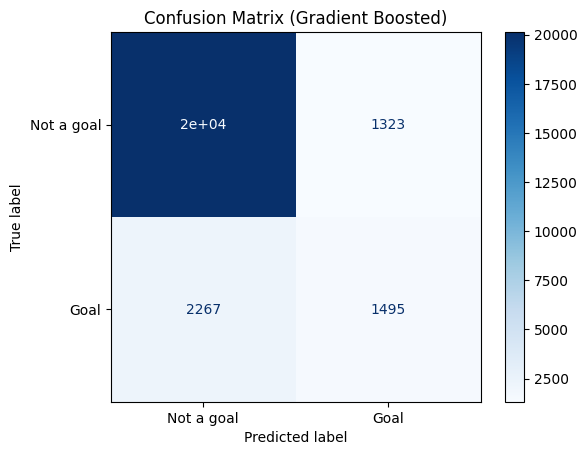


Gradient Boosted
Accuracy: 0.8576526566217287
Precision: 0.5305180979418027
Recall: 0.3973950026581606
F1: 0.45440729483282677


In [251]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
gbt_pred = [math.ceil(x[1]-0.24) for x in gbt_xg]
calculate_stats(gbt_pred, y_test, "Gradient Boosted")